**Name**: Diran Suraj

**PI**: Z7279378

# TM358 TMA 02 Question 2

# Introduction to TMA02

You should be able to work on this TMA when you have completed Block 2 and Block 3 of the module. This TMA will be focused on completing a sentiment analysis task using two types of deep neural network, namely RNN (Block 3) and CNN (Block 2) and compare the results. 

The Amazon review dataset (https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews) is used in this TMA for sentiment analysis. The pre-processed dataset can be found in the directory /datasets/amazon-reviews/, divided into training, validation and test sets. The dataset has been adapted so that there is a rating of 0=negative and 1=positive for each review document.


# Question 2 (45 marks)

In Block 2, you have seen how CNN is used to classify images. Indeed, CNN can also be used for text classification, by applying a filter (kernel) on a sequence of word embedding vectors. 

Indeed, CNN can also be used for text classification, by applying a filter (kernel) on a sequence of word embedding vectors (which is similar to a matrix of pixels in image classification). As illustrated in the following figure (which is adapted from https://cezannec.github.io/CNN_Text_Classification/), the height of the filter will be the number of words in the sequence it that we would like to consider as correlated. The width of the kernel should span the length of an entire word embedding. 


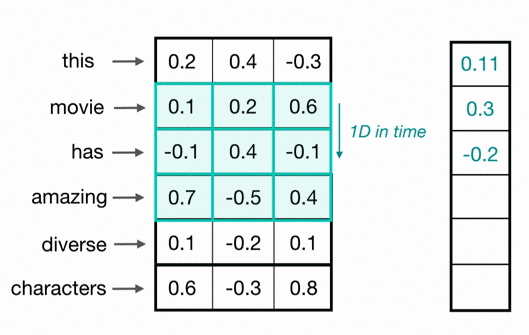

Each input sequence will be limited to the same length. The filter will slide one-by-one down the sequence of word embeddings. Each embedding vector in the original sequence will be transformed into one convolved value, capturing the relationship between words within the filter window. This is called a *1D convolution*. The output will be a feature vector of the same length as the input sequence. 
Similar to the use of CNN for image classification, multiple filters can be applied to detect different kinds of features that may be useful for the task. Once we have got each feature vector, a max-pooling operation is often used to retain only the maximum value in the vector, which is considered as the most useful feature. The max-values produced by processing each of the feature vectors will be concatenated and passed to one or more fully connected (dense) layer that can produce the final classification result. As this TMA is concerned about binary classification (i.e., positive or negative sentiment), the final layer just needs to output a single value through a softmax or a sigmoid function. A final output value close to 0 indicates a negative review, otherwise a value close to 1 indicates a positive review.

By completing Question 2 of this TMA, you will have shown your understanding of the following learning outcomes:  

* Design of 1D CNN models for text classification, more specifically sentiment analysis.
* Investigate and evaluate different hyperparameters for creating and training models.
* Present the evaluation of the models.

In this notebook, example code for loading the data and building 1D CNN has been provided. Then you will start working on the sub-questions. Record all your activity and observations in this notebook. Insert additional notebook cells as required. 

Include Markdown cells liberally in your solutions, to describe what you are doing. This will help your tutor give full credit for all you have done, and is invaluable in reminding you what you were doing when you return to the TMA after a few days away.

See the VLE for details of how to submit your completed notebook. You should submit only this notebook file for this question.

## Important note about training and saving the model

Ensure that the code cell where you train the model also includes saving of the model and training history. This is a large dataset and models will take some time to train. You can leave the model to train while you do something else (ensure your PC does not go to sleep). 

Once training is finished and the container is idle, it will shut down after a while. If you save the model as soon as it has finished training (in the same notebook cell), you can load the model on your return. If you don't save the model, you will lose that work. 

Below is an example of how to do this.

## Marks are based on process, not results

In this notebook, you will be asked to create, train, and evaluate several neural networks. Training neural networks is inherently a stochastic process, based on the random allocation of initial weights and the shuffled order of training examples. Therefore, your results will differ from results generated by other students, and those generated by the module team and presented in the tutor's marking guide.

The marks in this question are awarded solely on your ability to carry out the steps of training and evaluation, not on any particular results you may achieve. **There are no thresholds for accuracy (or any other metric) you must achieve.** You will gain credit for carrying out the tasks specified in this question, including honest evaluations of how the models perform. 

## Taking a section of the training dataset

As the dataset is very large, it can take a long time to train a model. Instead, you will use and compare several reduced sizes of the dataset used for training in this TMA. 

The `shard` operation takes a fraction of the dataset. `shard(n, k)` will split the dataset into `n` fragments and keep just the `k`th one (indexed from zero). For instance, `shard(10, 0)` will split the dataset into ten pieces and keep just the zeroth one (i.e. take a tenth of the data); `shard(2, 0)` will split the dataset into two pieces and keep the zeroth one (i.e. take half the data). 

In this notebook, four versions of the training data are loaded, each representing a different fraction of the full training data.

## Importing the required libraries

In [3]:
import numpy as np
import tensorflow as tf
import json
import scipy

import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets, metrics, Sequential, utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

from tensorflow.keras.layers import Dense, Embedding, LSTM


## Creating some constants

In [4]:
BATCH_SIZE = 512

In [5]:
METRICS = [
      lambda : tf.keras.metrics.TruePositives(name='tp'),
      lambda : tf.keras.metrics.FalsePositives(name='fp'),
      lambda : tf.keras.metrics.TrueNegatives(name='tn'),
      lambda : tf.keras.metrics.FalseNegatives(name='fn'), 

      lambda : tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      lambda : tf.keras.metrics.Precision(name='precision'),
      lambda : tf.keras.metrics.Recall(name='recall'),
]

def fresh_metrics():
    return [metric() for metric in METRICS]

## Loading the data

In [6]:
train_filename = '/datasets/amazon-reviews/train.csv'
val_filename = '/datasets/amazon-reviews/validation.csv'
test_filename = '/datasets/amazon-reviews/test.csv'

In [7]:
train_data = tf.data.experimental.make_csv_dataset(train_filename, batch_size=BATCH_SIZE, num_epochs=1)
train_data = train_data.map(lambda d: (d['Review'], d['Rating']))

In [8]:
# take 10% of the training data
train_data10 = train_data.shard(10, 0)

train_data10 = train_data10.cache()
train_data10 = train_data10.shuffle(50000)
train_data10 = train_data10.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [9]:
# take 25% of the training data
train_data25 = train_data.shard(4, 0)

train_data25 = train_data25.cache()
train_data25 = train_data25.shuffle(50000)
train_data25 = train_data25.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [10]:
# take 50% of the training data
train_data50 = train_data.shard(2, 0)

train_data50 = train_data50.cache()
train_data50 = train_data50.shuffle(50000)
train_data50 = train_data50.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [11]:
# use all the training data
train_data = train_data.cache()
train_data = train_data.shuffle(50000)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [12]:
validation_data = tf.data.experimental.make_csv_dataset(val_filename, batch_size=BATCH_SIZE, num_epochs=1)
validation_data = validation_data.map(lambda d: (d['Review'], d['Rating']))
validation_data = validation_data.cache()
validation_data = validation_data.prefetch(buffer_size=tf.data.AUTOTUNE) 

In [13]:
test_data = tf.data.experimental.make_csv_dataset(test_filename, batch_size=BATCH_SIZE, num_epochs=1)
test_data = test_data.map(lambda d: (d['Review'], d['Rating']))
test_data = test_data.cache()
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

## Creating encoders

The following code creates and saves text encoders for different vocabulary sizes. Running this code will take some time, but this saves the files for use later.

After your first run of this notebook, you can comment out the cells that adapt and save the encoders.

In [14]:
!mkdir encoder100
!mkdir encoder200
!mkdir encoder300

mkdir: cannot create directory ‘encoder100’: File exists
mkdir: cannot create directory ‘encoder200’: File exists
mkdir: cannot create directory ‘encoder300’: File exists


### Create, adapt, and save an encoder

You will only need to do this once. You may like to comment out the code in these cells after the first run.

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=100)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder100')

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=200)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder200')

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=300)
encoder.adapt(train_data.map(lambda text, _label: text))
encoder.save_assets('encoder300')

### Create an encoder and load its assets from file

In [15]:
encoder100 = tf.keras.layers.TextVectorization(output_sequence_length=100,max_tokens=100)
encoder100.load_assets('encoder100')

In [16]:
encoder200 = tf.keras.layers.TextVectorization(output_sequence_length=100,max_tokens=200)
encoder200.load_assets('encoder200')

In [17]:
encoder300 = tf.keras.layers.TextVectorization(output_sequence_length=100,max_tokens=300)
encoder300.load_assets('encoder300')

## Example 1D CNN model

The following is an example 1D CNN model, using a vocabulary size of 100 words, word embedding length of 16, a 1D convolution layer (4 filters, kernel size of 5, activation function relu), a max-pooling layer, a dense layer of 64 nodes (activation function relu), and a final binary classification with sigmoid function.  It is trained over 5 epochs with 10% of the training dataset.

The model and training records are saved as `example_CNN_model`.

In [19]:
# Build a model
EMBEDDING_LEN = 16  # The length of the word embedding vector
KERNEL_SIZE = 5

example_CNN_model = Sequential([
    encoder100,
    Embedding(input_dim=len(encoder100.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    Conv1D(filters=4, kernel_size=KERNEL_SIZE, padding='same', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [20]:
# Compile the model
example_CNN_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
example_CNN_history = example_CNN_model.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1
)

# Save the trained model and training history
example_CNN_model.save('example_CNN_review.keras')
with open('example_CNN_review_history.json', 'w') as f:
    json.dump(example_CNN_history.history, f)
    

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    703/Unknown 56s 14ms/step - accuracy: 0.6482 - loss: 0.6183

/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


704/704 ━━━━━━━━━━━━━━━━━━━━ 59s 18ms/step - accuracy: 0.6483 - loss: 0.6182 - val_accuracy: 0.7161 - val_loss: 0.5481
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7176 - loss: 0.5470 - val_accuracy: 0.7254 - val_loss: 0.5363
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7254 - loss: 0.5386 - val_accuracy: 0.7277 - val_loss: 0.5325
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.7280 - loss: 0.5339 - val_accuracy: 0.7298 - val_loss: 0.5307
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7290 - loss: 0.5319 - val_accuracy: 0.7328 - val_loss: 0.5281


In [21]:
# Reload the model and training history
example_CNN_model = tf.keras.models.load_model('example_CNN_review.keras')
with open('example_CNN_review_history.json') as f:
    example_CNN_history = json.load(f)

In [22]:
# Print a summary of model structure and parameters
print(f'Model Structure and Parameters')
example_CNN_model.summary()

Model Structure and Parameters


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_3            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 16)        │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 4)         │           324 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 4)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,929 (27.07 KB)

 Trainable params: 2,309 (9.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,620 (18.05 KB)

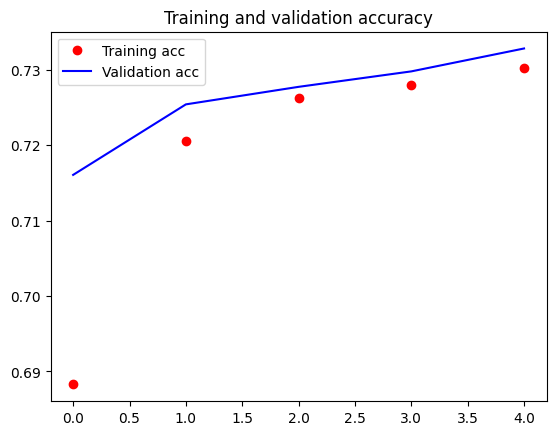

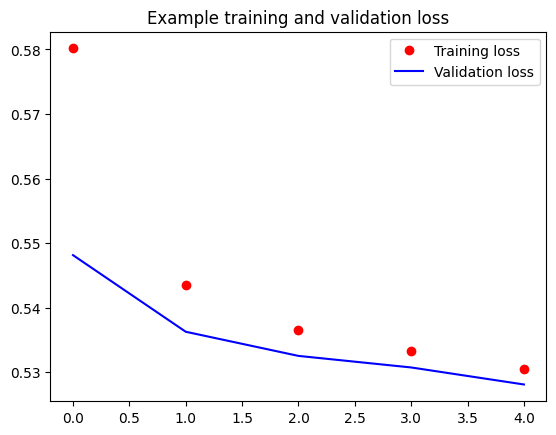

In [23]:
# Plot the training history

acc = example_CNN_history['accuracy']
val_acc = example_CNN_history['val_accuracy']
loss = example_CNN_history['loss']
val_loss = example_CNN_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Example training and validation loss')
plt.legend()

plt.show()

In [24]:
# Evaluate the trained model

example_CNN_model_results = example_CNN_model.evaluate(test_data, return_dict=True)
example_CNN_model_results

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7288 - loss: 0.5346


{'accuracy': 0.728668749332428, 'loss': 0.5326552391052246}

# You are now ready to attempt TMA02 Question 2

# Q2a - 9 marks: Create and train the following 1D CNN models for sentiment classification

This part of your investigation is to create and train various 1D CNN models with varying size of vobabulary, length of word embedding vectors, number of filters and size of kernel.
 
For your models you should:

* use 10% of the training data
* train for 5 epochs, using binary_crossentropy as loss, adam as optimizer, and acuracy as metric.

(1) Create the following three 1D CNN models, which involve 4 LSTM units with varying word embedding length and vocabulary size, followed by a dense layer with 1 node and a sigmoid activation for final classification. (6 marks)

* CNN_model_1: using 200-word encoder, word embedding length of 16, with a 1D convolution layer (32 filters, kernel size of 5)
* CNN_model_2: using 300-word encoder, word embedding length of 16, with a 1D convolution layer (32 filters, kernel size of 5)
* CNN_model_3: using 300-word encoder, word embedding length of 16, with a 1D convolution layer (64 filters, kernel size of 3)

* For all the above models, the final 1D CNN layer is followed by a max-pooling layer, a dense layer of 64 nodes (activation function relu), and a dense layer of one node (with sigmoid activation) for final classification.

(2) Train the above models, print a summary of each model's structure and parameters, and produce training and validation graphs for the models (3 marks)


## Build the required models

In [18]:
# Build a model
EMBEDDING_LEN = 16  # The length of the word embedding vector
KERNEL_SIZE = 5

CNN_model_1 = Sequential([
    encoder200,
    Embedding(input_dim=len(encoder200.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    Conv1D(filters=32, kernel_size=KERNEL_SIZE, padding='same', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [19]:
# Build a model
EMBEDDING_LEN = 16  # The length of the word embedding vector
KERNEL_SIZE = 5

CNN_model_2 = Sequential([
    encoder300,
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    Conv1D(filters=32, kernel_size=KERNEL_SIZE, padding='same', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [20]:
# Build a model
EMBEDDING_LEN = 16  # The length of the word embedding vector
KERNEL_SIZE = 3

CNN_model_3 = Sequential([
    encoder300,
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    Conv1D(filters=64, kernel_size=KERNEL_SIZE, padding='same', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


Train the models, show their structures and parameters, and produce training and validation curves

### CNN_model_1

In [21]:
# Compile the model
CNN_model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
CNN_model_1_history = CNN_model_1.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1
)

# Save the trained model and training history
CNN_model_1.save('CNN_model_1_review.keras')
with open('CNN_model_1_review_history.json', 'w') as f:
    json.dump(CNN_model_1_history.history, f)
    
    

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


    701/Unknown 36s 11ms/step - accuracy: 0.6994 - loss: 0.5603

/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.6996 - loss: 0.5600 - val_accuracy: 0.7795 - val_loss: 0.4544
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7886 - loss: 0.4451 - val_accuracy: 0.7943 - val_loss: 0.4325
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8001 - loss: 0.4267 - val_accuracy: 0.7994 - val_loss: 0.4252
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8065 - loss: 0.4161 - val_accuracy: 0.8009 - val_loss: 0.4226
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8103 - loss: 0.4095 - val_accuracy: 0.8035 - val_loss: 0.4175


In [22]:
# Reload the model and training history
CNN_model_1 = tf.keras.models.load_model('CNN_model_1_review.keras')
with open('CNN_model_1_review_history.json') as f:
    CNN_model_1_history = json.load(f)

In [23]:
# Print a summary of model structure and parameters
print(f'Model Structure and Parameters')
CNN_model_1.summary()

Model Structure and Parameters


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 16)        │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,909 (93.40 KB)

 Trainable params: 7,969 (31.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,940 (62.27 KB)

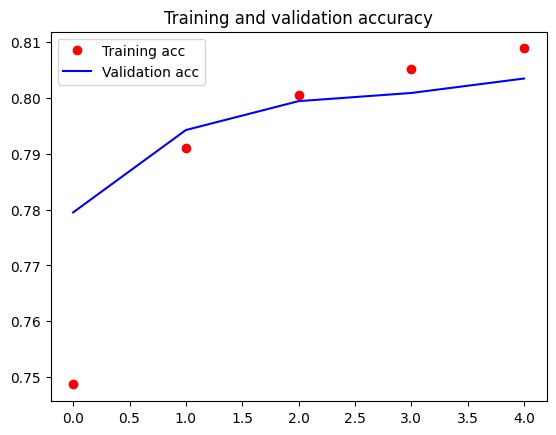

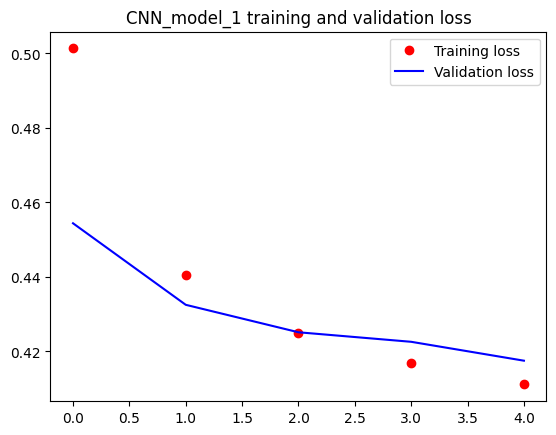

In [25]:
# Plot the training history

acc = CNN_model_1_history['accuracy']
val_acc = CNN_model_1_history['val_accuracy']
loss = CNN_model_1_history['loss']
val_loss = CNN_model_1_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN_model_1 training and validation loss')
plt.legend()

plt.show()

### CNN_model_2

In [26]:
# Compile the model
CNN_model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
CNN_model_2_history = CNN_model_2.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1
)

# Save the trained model and training history
CNN_model_2.save('CNN_model_2_review.keras')
with open('CNN_model_2_review_history.json', 'w') as f:
    json.dump(CNN_model_2_history.history, f)
    
    

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7227 - loss: 0.5291 - val_accuracy: 0.8058 - val_loss: 0.4111
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8124 - loss: 0.4068 - val_accuracy: 0.8172 - val_loss: 0.3935
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8224 - loss: 0.3879 - val_accuracy: 0.8219 - val_loss: 0.3873
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8291 - loss: 0.3777 - val_accuracy: 0.8263 - val_loss: 0.3806
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8340 - loss: 0.3697 - val_accuracy: 0.8279 - val_loss: 0.3788


In [27]:
# Reload the model and training history
CNN_model_2 = tf.keras.models.load_model('CNN_model_2_review.keras')
with open('CNN_model_2_review_history.json') as f:
    CNN_model_2_history = json.load(f)

In [28]:
# Print a summary of model structure and parameters
print(f'Model Structure and Parameters')
CNN_model_2.summary()

Model Structure and Parameters


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 16)        │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,709 (112.15 KB)

 Trainable params: 9,569 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,140 (74.77 KB)

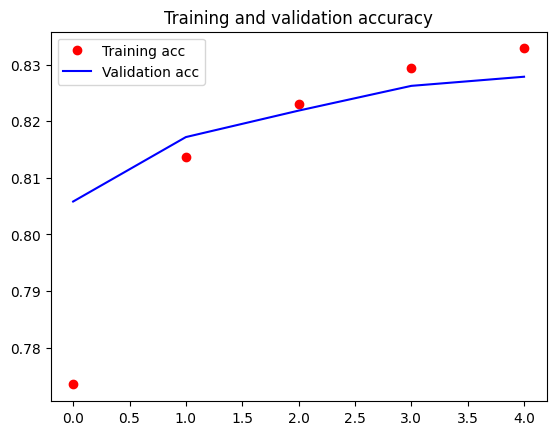

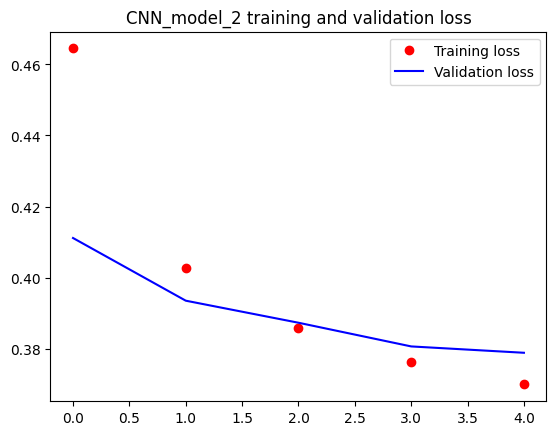

In [29]:
# Plot the training history

acc = CNN_model_2_history['accuracy']
val_acc = CNN_model_2_history['val_accuracy']
loss = CNN_model_2_history['loss']
val_loss = CNN_model_2_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN_model_2 training and validation loss')
plt.legend()

plt.show()

### CNN_model_3

In [30]:
# Compile the model
CNN_model_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
CNN_model_3_history = CNN_model_3.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1
)

# Save the trained model and training history
CNN_model_3.save('CNN_model_3_review.keras')
with open('CNN_model_3_review_history.json', 'w') as f:
    json.dump(CNN_model_3_history.history, f)
    
    

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7198 - loss: 0.5280 - val_accuracy: 0.8061 - val_loss: 0.4116
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8146 - loss: 0.4038 - val_accuracy: 0.8211 - val_loss: 0.3883
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8257 - loss: 0.3848 - val_accuracy: 0.8238 - val_loss: 0.3827
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8331 - loss: 0.3719 - val_accuracy: 0.8290 - val_loss: 0.3763
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8345 - loss: 0.3682 - val_accuracy: 0.8310 - val_loss: 0.3733


In [31]:
# Reload the model and training history
CNN_model_3 = tf.keras.models.load_model('CNN_model_3_review.keras')
with open('CNN_model_3_review_history.json') as f:
    CNN_model_3_history = json.load(f)

In [32]:
# Print a summary of model structure and parameters
print(f'Model Structure and Parameters')
CNN_model_3.summary()

Model Structure and Parameters


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 100, 16)        │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 100, 64)        │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,485 (142.52 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,324 (95.02 KB)

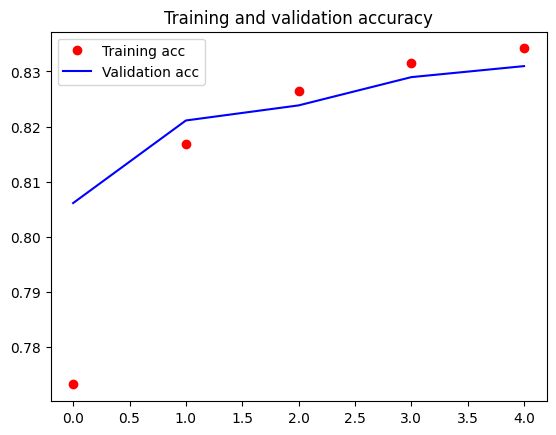

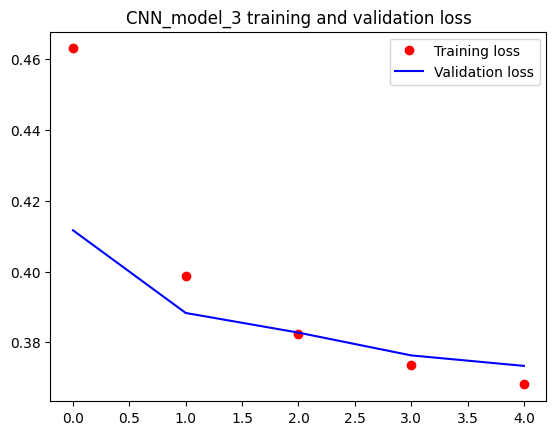

In [33]:
# Plot the training history

acc = CNN_model_3_history['accuracy']
val_acc = CNN_model_3_history['val_accuracy']
loss = CNN_model_3_history['loss']
val_loss = CNN_model_3_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN_model_3 training and validation loss')
plt.legend()

plt.show()

# Q2b - 6 marks: Evaluate the trained 1D CNN models

The second part of your investigation is to evaluate the models you have trained in Q2a with the test dataset and compare the results.

* Evaluate the trained models on the test dataset in term of accuracy (3 marks)
* Compare the results of different models (3 marks)
  

## Evaluate the trained models on the test data

In [34]:
# Evaluate the trained model

CNN_model_1_results = CNN_model_1.evaluate(test_data, return_dict=True)
CNN_model_1_results


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8029 - loss: 0.4212


{'accuracy': 0.8039125204086304, 'loss': 0.41988834738731384}

In [35]:
# Evaluate the trained model

CNN_model_2_results = CNN_model_2.evaluate(test_data, return_dict=True)
CNN_model_2_results


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8269 - loss: 0.3817


{'accuracy': 0.8268718719482422, 'loss': 0.38120803236961365}

In [36]:
# Evaluate the trained model

CNN_model_3_results = CNN_model_3.evaluate(test_data, return_dict=True)
CNN_model_3_results

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8293 - loss: 0.3776


{'accuracy': 0.8283156156539917, 'loss': 0.37769708037376404}

## Compare and comment on the results

Increasing Vocabulary Size Improves Accuracy

Comparing CNN_model_1 (200-word encoder, 0.8039 accuracy) and CNN_model_2 (300-word encoder, 0.8269 accuracy), we see a significant improvement in classification accuracy.
This suggests that a larger vocabulary enables the model to better capture key words and context within customer reviews.

A 200-word encoder limits the model’s ability to recognize less common but important words, while a 300-word encoder provides a richer representation of the text.
This is particularly beneficial for sentiment analysis, where specific words (e.g., “disappointing,” “amazing,” “poor”) play a crucial role in determining polarity.

Increasing the Number of Filters Slightly Improves Performance

CNN_model_3 (64 filters) achieves slightly higher accuracy (0.8283) compared to CNN_model_2 (32 filters, 0.8269).

Filters in convolutional layers function as feature detectors, identifying important patterns in text data.
More filters mean the model can capture a wider variety of patterns (e.g., common phrases, emotional keywords, negations), but the marginal improvement suggests diminishing returns.
Adding too many filters can increase computational cost without significant accuracy gains.

Reducing Kernel Size (5 → 3) Has Minimal Impact

CNN_model_2 and CNN_model_3 differ only in kernel size (5 vs. 3), yet their accuracies are almost identical (0.8269 vs. 0.8283).

Kernel size determines the n-gram patterns the model captures: A kernel size of 5 extracts longer contextual relationships between words. A kernel size of 3 focuses on shorter phrases and local patterns.

The minimal accuracy difference suggests that both kernel sizes effectively capture sentiment-related information, making it a less critical hyperparameter in this case.

# Q2c - 18 marks: Create, train and evaluate your own improved 1D CNN models

The third part of investigation is to design, train and test extended 1D CNN models that can further improve the test accuracy over *CNN_model_3* in Q2b. Your choice of  hyper-parameters, such as the vobabulary size, word embedding length, number of filters, kernel size, and number of convolution layers, should be justified and verified by the results. You may test as many as possible model designs but you just need to include two best performing ones in your solution. 

* Create your own extended models. Each model should achieve a better test accuracy than *CNN_model_3* and involve at least two of the above-mentioned hyper-parameters that are different from *CNN_model_3*. (6 marks)
* Train your extended models, print a summary of each model's structure and parameters, and produce the training/validation graphs. (4 marks)
* Test your models on the test dataset and report their accuracies. (2 marks)
* Compare the results of your models against *CNN_model_3*, and discuss how these hyper-parameters influence the model performance. (6 marks)

For your models you should:

* use 10% of the training data
* train for 5 epochs, using binary_crossentropy as loss, adam as optimizer, and acuracy as metric.

## Create the extended models

In [40]:
EMBEDDING_LEN = 32  # Increased from 16
KERNEL_SIZE = 3

Extended_CNN_model_1 = Sequential([
    encoder300, 
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    Conv1D(filters=64, kernel_size=KERNEL_SIZE, activation='relu'),
    Conv1D(filters=64, kernel_size=KERNEL_SIZE, activation='relu'),  # Added second convolutional layer
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [41]:
EMBEDDING_LEN = 16  
KERNEL_SIZE = 5  # Increased from 3

Extended_CNN_model_2 = Sequential([
    encoder300,  
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
    Conv1D(filters=128, kernel_size=KERNEL_SIZE, activation='relu'), # increase filters from 64 to 128
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

## Train the extended models, show their structures and parameters, and produce training and validation curves

### Extended_CNN_Model_1

In [42]:
# Compile the model
Extended_CNN_model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
Extended_CNN_model_1_history = Extended_CNN_model_1.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1
)

# Save the trained model and training history
Extended_CNN_model_1.save('Extended_CNN_model_1_review.keras')
with open('Extended_CNN_model_1_review_history.json', 'w') as f:
    json.dump(Extended_CNN_model_1_history.history, f)
    
    

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'conv1d_6' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7319 - loss: 0.5196 - val_accuracy: 0.8101 - val_loss: 0.4047
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8192 - loss: 0.3941 - val_accuracy: 0.8224 - val_loss: 0.3856
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8337 - loss: 0.3684 - val_accuracy: 0.8321 - val_loss: 0.3702
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8401 - loss: 0.3578 - val_accuracy: 0.8361 - val_loss: 0.3618
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8462 - loss: 0.3465 - val_accuracy: 0.8361 - val_loss: 0.3617


In [43]:
# Reload the model and training history
Extended_CNN_model_1 = tf.keras.models.load_model('Extended_CNN_model_1_review.keras')
with open('Extended_CNN_model_1_review_history.json') as f:
    Extended_CNN_model_1_history = json.load(f)

In [44]:
# Print a summary of model structure and parameters
print(f'Model Structure and Parameters')
Extended_CNN_model_1.summary()

Model Structure and Parameters


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 100, 32)        │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 98, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 96, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,157 (379.52 KB)

 Trainable params: 32,385 (126.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 64,772 (253.02 KB)

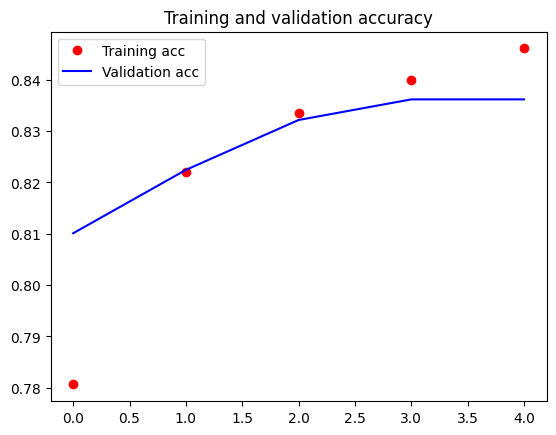

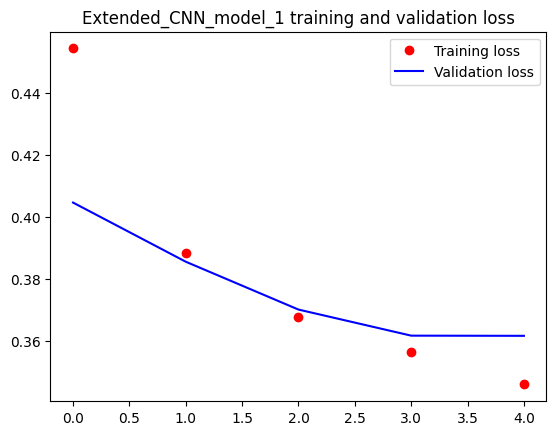

In [45]:
# Plot the training history

acc = Extended_CNN_model_1_history['accuracy']
val_acc = Extended_CNN_model_1_history['val_accuracy']
loss = Extended_CNN_model_1_history['loss']
val_loss = Extended_CNN_model_1_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Extended_CNN_model_1 training and validation loss')
plt.legend()

plt.show()

### Extended_CNN_Model_2

In [46]:
# Compile the model
Extended_CNN_model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
Extended_CNN_model_2_history = Extended_CNN_model_2.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1
)

# Save the trained model and training history
Extended_CNN_model_2.save('Extended_CNN_model_2_review.keras')
with open('Extended_CNN_model_2_review_history.json', 'w') as f:
    json.dump(Extended_CNN_model_2_history.history, f)
    
    

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'conv1d_8' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7213 - loss: 0.5223 - val_accuracy: 0.8142 - val_loss: 0.4009
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8193 - loss: 0.3952 - val_accuracy: 0.8258 - val_loss: 0.3822
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8301 - loss: 0.3738 - val_accuracy: 0.8324 - val_loss: 0.3704
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8415 - loss: 0.3552 - val_accuracy: 0.8343 - val_loss: 0.3666
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8446 - loss: 0.3498 - val_accuracy: 0.8368 - val_loss: 0.3625


In [47]:
# Reload the model and training history
Extended_CNN_model_2 = tf.keras.models.load_model('Extended_CNN_model_2_review.keras')
with open('Extended_CNN_model_2_review_history.json') as f:
    Extended_CNN_model_2_history = json.load(f)

In [48]:
# Print a summary of model structure and parameters
print(f'Model Structure and Parameters')
Extended_CNN_model_2.summary()

Model Structure and Parameters


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 100, 16)        │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 96, 128)        │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,469 (275.27 KB)

 Trainable params: 23,489 (91.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,980 (183.52 KB)

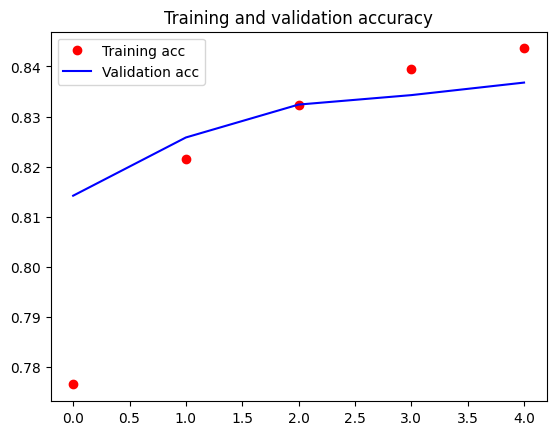

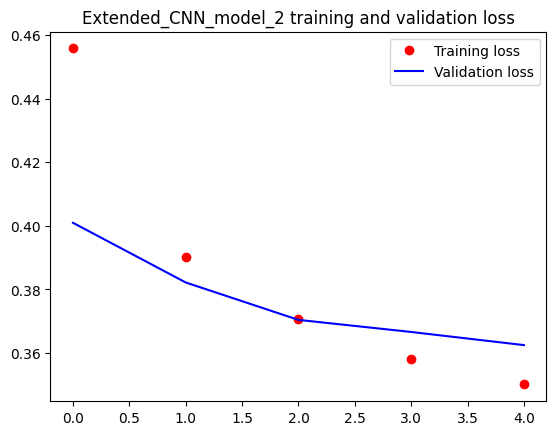

In [49]:
# Plot the training history

acc = Extended_CNN_model_2_history['accuracy']
val_acc = Extended_CNN_model_2_history['val_accuracy']
loss = Extended_CNN_model_2_history['loss']
val_loss = Extended_CNN_model_2_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Extended_CNN_model_2 training and validation loss')
plt.legend()

plt.show()

## Evaluate the trained models on the test data

In [50]:
Extended_CNN_model_1_results = Extended_CNN_model_1.evaluate(test_data, return_dict=True)
Extended_CNN_model_1_results

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8344 - loss: 0.3655


{'accuracy': 0.835059404373169, 'loss': 0.3652256429195404}

In [51]:
Extended_CNN_model_2_results = Extended_CNN_model_2.evaluate(test_data, return_dict=True)
Extended_CNN_model_2_results

625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8356 - loss: 0.3655


{'accuracy': 0.8354843854904175, 'loss': 0.3656109571456909}

## Compare and comment on the results

Extended_CNN_Model_1, aimed to improve feature extraction by increasing the embedding length from 16 to 32 and adding an extra Conv1D layer. A larger embedding space allows for better word representations, while a deeper network enables hierarchical feature learning. This model achieved an accuracy of 0.8351, indicating that expanding the embedding representation and adding depth helped extract more meaningful text patterns, leading to improved classification performance.

Extended_CNN_Model_2, focused on strengthening the feature extraction layer by increasing the number of filters from 64 to 128 and expanding the kernel size from 3 to 5. More filters enable the network to detect a wider variety of patterns in the text, while a larger kernel allows it to capture longer word sequence. This model performed slightly better than the first, achieving an accuracy of 0.8355, suggesting that optimizing convolutional layer parameters had a greater impact on performance than simply adding depth.

When comparing both models, it was observed that both approaches led to a similar accuracy improvement of approximately 0.7% over CNN_model_3. However, Extended_CNN_Model_2 performed slightly better, indicating that increasing filters and kernel size may be more beneficial than adding extra layers. This suggests that a stronger feature extraction layer enables the network to capture sentiment-related patterns more effectively.

# Q2d - 12 marks: Create, train and evaluate further improved models by combineing 1D CNN and LSTM

The final part of investigation is to explore further improving 1D CNN by combining it with LSTM. A typical way is to first use one or more 1D convolution layers, followed by a maxpooling layer (e.g., MaxPooling1D(pool_size=2), which uses the pool_size of 2 to halve the feature map size), to get a sequence of spatial feature maps for good and bad sentiment. The consolidated feature maps can then be fed into one or more LSTMs to further capture relevant temporal features. After the LSTM, a dense layer of one node (with sigmoid function) is used for final classification. You may test as many as possible model designs but just need to include two best performing ones in your solution.
  
* Create at least two combination models. (4 marks)
* Train your combined models, print a summary of each model's structure and parameters, and produce the training/validation graphs. (2 marks)
* Test your models on the test dataset and report their accuracies. (2 marks)
* Compare the results of each combination model against the use of its 1D CNN part individually. (4 marks)

For your models you should:

* use 10% of the training data
* train for 5 epochs, using binary_crossentropy as loss, adam as optimizer, and acuracy as metric.

## Create the further improved models

In [74]:
EMBEDDING_LEN = 64  
KERNEL_SIZE = 5

CNN_LSTM_model_1 = Sequential([
    encoder300,  
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
        
    # CNN Layer for spatial feature extraction
    Conv1D(filters=256, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
        
    # LSTM Layer for temporal feature extraction
    LSTM(32),
        
    # Dense layer for binary classification
    Dense(1, activation='sigmoid')
])

In [80]:
EMBEDDING_LEN = 64  
KERNEL_SIZE = 5  

CNN_LSTM_model_2 = Sequential([
    encoder300,  
    Embedding(input_dim=len(encoder300.get_vocabulary()), output_dim=EMBEDDING_LEN, mask_zero=True),
        
    # CNN Layer for spatial feature extraction
    Conv1D(filters=256, kernel_size=KERNEL_SIZE, activation='relu'),
    MaxPooling1D(pool_size=2),
        
    # Stacked LSTM layers for temporal feature extraction
    LSTM(8, return_sequences=True),  
    LSTM(8, return_sequences=True),  
    LSTM(8), 
        
    # Dense layer for binary classification
    Dense(1, activation='sigmoid')
])

## Train the models, show a summary of each model's structure and parameters, and produce training and validation curves

### CNN_LSTM_model_1

In [75]:
# Compile the model
CNN_LSTM_model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
CNN_LSTM_model_1_history = CNN_LSTM_model_1.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1
)

# Save the trained model and training history
CNN_LSTM_model_1.save('CNN_LSTM_model_1_review.keras')
with open('CNN_LSTM_model_1_review_history.json', 'w') as f:
    json.dump(CNN_LSTM_model_1_history.history, f)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'conv1d_15' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.7154 - loss: 0.5270 - val_accuracy: 0.8256 - val_loss: 0.3825
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.8309 - loss: 0.3738 - val_accuracy: 0.8371 - val_loss: 0.3598
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.8486 - loss: 0.3433 - val_accuracy: 0.8495 - val_loss: 0.3378
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.8569 - loss: 0.3262 - val_accuracy: 0.8537 - val_loss: 0.3305
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.8662 - loss: 0.3094 - val_accuracy: 0.8536 - val_loss: 0.3308


In [76]:
# Reload the model and training history
CNN_LSTM_model_1 = tf.keras.models.load_model('CNN_LSTM_model_1_review.keras')
with open('CNN_LSTM_model_1_review_history.json') as f:
    CNN_LSTM_model_1_history = json.load(f)

In [77]:
# Print a summary of model structure and parameters
print(f'Model Structure and Parameters')
CNN_LSTM_model_1.summary()

Model Structure and Parameters


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_13 (Embedding)        │ (None, 100, 64)        │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 96, 256)        │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 415,205 (1.58 MB)

 Trainable params: 138,401 (540.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 276,804 (1.06 MB)

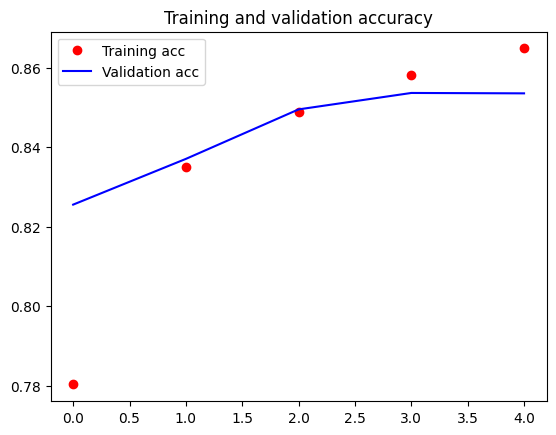

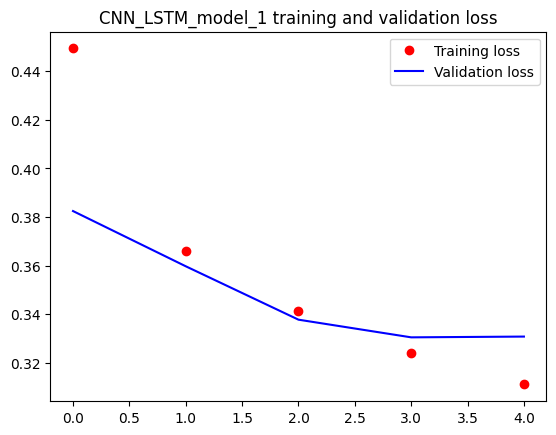

In [78]:
# Plot the training history

acc = CNN_LSTM_model_1_history['accuracy']
val_acc = CNN_LSTM_model_1_history['val_accuracy']
loss = CNN_LSTM_model_1_history['loss']
val_loss = CNN_LSTM_model_1_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN_LSTM_model_1 training and validation loss')
plt.legend()

plt.show()

### CNN_LSTM_model_2

In [81]:
# Compile the model
CNN_LSTM_model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
CNN_LSTM_model_2_history = CNN_LSTM_model_2.fit(
    train_data10, 
    validation_data=validation_data, 
    epochs=5, 
    verbose=1
)

# Save the trained model and training history
CNN_LSTM_model_2.save('CNN_LSTM_model_2_review.keras')
with open('CNN_LSTM_model_2_review_history.json', 'w') as f:
    json.dump(CNN_LSTM_model_2_history.history, f)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:847: UserWarning: Layer 'conv1d_16' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


704/704 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.7037 - loss: 0.5592 - val_accuracy: 0.8091 - val_loss: 0.4098
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8148 - loss: 0.4038 - val_accuracy: 0.8275 - val_loss: 0.3788
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.8359 - loss: 0.3650 - val_accuracy: 0.8418 - val_loss: 0.3516
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.8492 - loss: 0.3390 - val_accuracy: 0.8487 - val_loss: 0.3400
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.8584 - loss: 0.3240 - val_accuracy: 0.8528 - val_loss: 0.3319


In [82]:
# Reload the model and training history
CNN_LSTM_model_2 = tf.keras.models.load_model('CNN_LSTM_model_2_review.keras')
with open('CNN_LSTM_model_2_review_history.json') as f:
    CNN_LSTM_model_2_history = json.load(f)

In [83]:
# Print a summary of model structure and parameters
print(f'Model Structure and Parameters')
CNN_LSTM_model_2.summary()

Model Structure and Parameters


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_14 (Embedding)        │ (None, 100, 64)        │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 96, 256)        │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 48, 8)          │         8,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 48, 8)          │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,861 (1.27 MB)

 Trainable params: 110,953 (433.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 221,908 (866.83 KB)

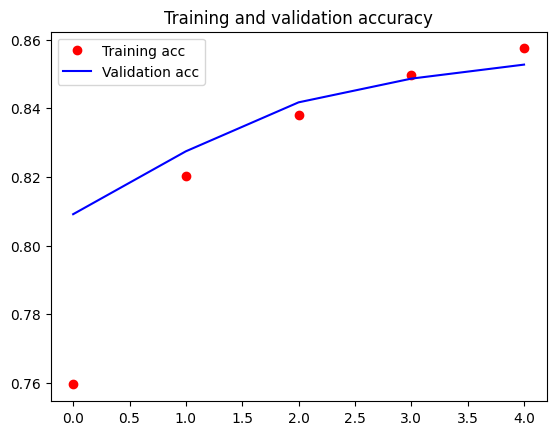

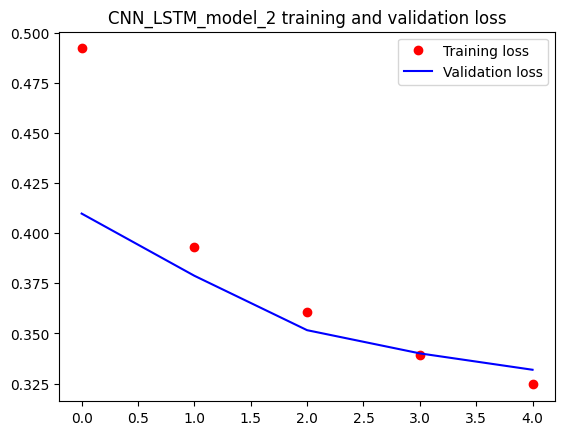

In [84]:
# Plot the training history

acc = CNN_LSTM_model_2_history['accuracy']
val_acc = CNN_LSTM_model_2_history['val_accuracy']
loss = CNN_LSTM_model_2_history['loss']
val_loss = CNN_LSTM_model_2_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('CNN_LSTM_model_2 training and validation loss')
plt.legend()

plt.show()

## Evaluate the trained models on the test data

In [79]:
CNN_LSTM_model_1_results = CNN_LSTM_model_1.evaluate(test_data, return_dict=True)
CNN_LSTM_model_1_results

625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8537 - loss: 0.3346


{'accuracy': 0.8540468811988831, 'loss': 0.3338865339756012}

In [68]:
CNN_LSTM_model_2_results = CNN_LSTM_model_2.evaluate(test_data, return_dict=True)
CNN_LSTM_model_2_results

625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8452 - loss: 0.3496


{'accuracy': 0.8448125123977661, 'loss': 0.3493945002555847}

## Compare and comment on the results

CNN_LSTM_model_1 achieved an accuracy of 85.4%, which is a strong performance considering the relatively simpler structure. The single LSTM layer is able to capture the necessary temporal dependencies in the data, and the convolutional layers do a good job extracting spatial features from the sequences. Given that this model is less complex than the second model, its training is likely more efficient, and it has a moderate number of parameters, reducing the chances of overfitting.

CNN_LSTM_model_2 achieved an accuracy of 84.5%, which is slightly lower than CNN_LSTM_model_1 by about 0.9%. Despite the increased number of LSTM layers, the performance doesn't seem to drastically improve. This suggests that while the stacked LSTM layers allow for a deeper extraction of temporal features, the added complexity may not be necessary or beneficial for this specific task. It’s possible that the added layers do not provide additional meaningful information, or they may be prone to overfitting.